Importing necessary modules

In [62]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from skimage import io, feature
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Mounting google drive to access the dataset stored in google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Video path of Actors 1 to 9
video_paths = []
for i in range(1, 10):
  video_paths.append("/content/drive/MyDrive/RAVDESS/Video_Song/Actor" + f"_0{i}/")


Extracting frames from each video and saving the frames into another directory 

In [ ]:
for video_path in video_paths:
  for filename in sorted(os.listdir(video_path)):
    video_cap = cv2.VideoCapture(os.path.join(video_path, filename))
    count = 0 # to keep track of number of frames captured
    flag = 1 # to check if the VideoCapture object is able to read next frame or not
    
    # Looping over to capture all the frames
    while flag == True:
      flag, image = video_cap.read() # reads the next frame from the VideoCapture object and sets flag to True if a frame is successfully read
      if flag:
        extracting_path = video_path + '/extracted_frames/' + str(filename[6:8]) + '_' + str(count) + '.jpg'
        cv2.imwrite(extracting_path, image)
        count += 1
        

/content/drive/MyDrive/RAVDESS/Video_Song/Actor_01/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_02/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_03/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_04/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_05/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_06/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_07/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_08/
/content/drive/MyDrive/RAVDESS/Video_Song/Actor_09/


Creating the data generator


In [5]:
file_paths = []
for video_path in video_paths:
  file_paths.extend(list(map(lambda x: video_path + 'extracted_frames/' + x, os.listdir(video_path + 'extracted_frames/'))))

file_labels = [int(file_path[68:70]) for file_path in file_paths]

# Creating a DataFrame from file_paths and file_labels
df = pd.DataFrame({'path': file_paths, 'label':file_labels})

# Writing DataFrame to a CSV file
csv_path = os.path.join(video_paths[0], os.pardir, 'csv_file/x_y.csv')
df.to_csv(csv_path, index=False)


In [6]:
# Reading the csv file
df = pd.read_csv(csv_path)

In [7]:
# Changing the data type to str since class_mode='sparse' requires to have labels in str type
df['label'] = df['label'].astype(str)

# Splitting df into train, val and test dataframes
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

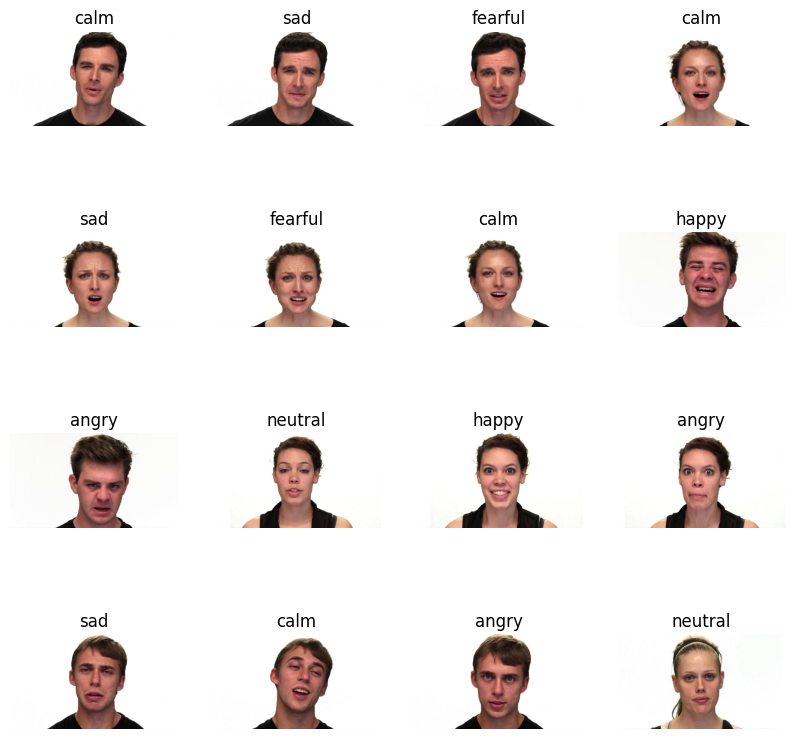

In [90]:
labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  img = Image.open(file_paths[300 * i])
  plt.imshow(img)
  plt.title(labels[file_labels[300 * i] - 1])
  plt.axis("off")

In [50]:
# Creating generator for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'path',
    y_col = 'label',
    target_size=(224, 224),
    batch_size=4000,
    class_mode='sparse'
)

# Creating generator for validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col = 'path',
    y_col = 'label',
    target_size=(224, 224),
    batch_size=1000,
    class_mode='sparse'
)

# Creating generator for testing data
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col = 'path',
    y_col = 'label',
    target_size=(224, 224),
    batch_size=1000,
    class_mode='sparse'
)

Found 5128 validated image filenames belonging to 6 classes.
Found 1282 validated image filenames belonging to 6 classes.
Found 1603 validated image filenames belonging to 6 classes.


Extracting HOG features 

In [12]:
# Creating a custom generator for applying HOG on the fly
def hog_generator(data_generator):
  for batch_x, batch_y in data_generator:
    x_hog = []
    for i in range(batch_x.shape[0]):
      fd, hog_image = feature.hog(batch_x[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
      x_hog.append(fd)

    yield x_hog, batch_y

In [51]:
# print(len(train_generator))
train_hog = hog_generator(train_generator)
val_hog = hog_generator(val_generator)
test_hog = hog_generator(test_generator)

# Transforming this generator to tf.data.Dataset generator
# Training data
tf_train_hog = tf.data.Dataset.from_generator(lambda: train_hog,
                                              output_types = (tf.float32, tf.int32),
                                              output_shapes = ([None, 26244], [None])
                                              )
# tf_train_hog = tf_train_hog.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation data
tf_val_hog = tf.data.Dataset.from_generator(lambda:val_hog,
                                              output_types = (tf.float32, tf.int32),
                                              output_shapes = ([None, 26244], [None])
                                              )
# tf_val_hog = tf_train_hog.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test data
tf_test_hog = tf.data.Dataset.from_generator(lambda:test_hog,
                                              output_types = (tf.float32, tf.int32),
                                              output_shapes = ([None, 26244], [None])
                                              )
# tf_test_hog = tf_train_hog.prefetch(buffer_size=tf.data.AUTOTUNE)


In [52]:
# Getting a batch of data from generator
batch_train_x, batch_train_y = next(iter(tf_train_hog))
batch_val_x, batch_val_y = next(iter(tf_val_hog))
batch_test_x, batch_test_y = next(iter(tf_test_hog))


<ipython-input-12-32cc2c7b7b4a>:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = feature.hog(batch_x[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)


Fitting Traditional Models

In [53]:
# Fitting Gaussian classifier
gauss_model = GaussianNB().fit(batch_train_x.numpy(), batch_train_y.numpy())
print('Train score:', gauss_model.score(batch_train_x.numpy(), batch_train_y.numpy()))
print('Validation score:', gauss_model.score(batch_val_x.numpy(), batch_val_y.numpy()))
print('Test score:', gauss_model.score(batch_test_x.numpy(), batch_test_y.numpy()))

Train score: 0.848
Validation score: 0.801
Test score: 0.787


In [54]:
# Fitting SVM
svc_model = SVC(kernel='rbf').fit(batch_train_x.numpy(), batch_train_y.numpy())
print('Train score:', svc_model.score(batch_train_x.numpy(), batch_train_y.numpy()))
print('Validation score:', svc_model.score(batch_val_x.numpy(), batch_val_y.numpy()))
print('Test score:', svc_model.score(batch_test_x.numpy(), batch_test_y.numpy()))

Train score: 0.9975
Validation score: 0.992
Test score: 0.993


In [56]:
# Fitting LDA
lda_model = LinearDiscriminantAnalysis().fit(batch_train_x.numpy(), batch_train_y.numpy())
print('Train score:', lda_model.score(batch_train_x.numpy(), batch_train_y.numpy()))
print('Validation score:', lda_model.score(batch_val_x.numpy(), batch_val_y.numpy()))
print('Test score:', lda_model.score(batch_test_x.numpy(), batch_test_y.numpy()))

Train score: 0.997
Validation score: 0.99
Test score: 0.989
